In [1]:
from cadcad.spaces import space
from cadcad.dynamics import block
from cadcad.spaces import Bit, Real, Integer, EmptySpace
from cadcad.points import Point
from cadcad.systems import Experiment
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
@space
class CartesianPlane:
    x:float
    y:float

CartesianPlaneDot = CartesianPlane.rename_dims({'x':'dx', 'y':'dy'})

In [3]:
@space
class Particle:
    pos:CartesianPlane
    vel:CartesianPlaneDot
    # used to encode a constraint
    #but this is exactly the kind of thing
    #i would like to push into the model params
    maxspeed : float

In [4]:

#this block serves as a kind of constraint checker for Particle
#i would like to be able to assign this block to the Space Paricle
#as a builtin constraint
@block
def isValidParticle(domain:Point[Particle])-> Point[Bit]:
    input = deepcopy(domain)
    dx= input['vel']['dx']
    dy= input['vel']['dy']

    vmax = input['maxspeed']

    output = {'bit':bool(dx**2+dy**2<=vmax**2)}

    return Point(Bit, output)

In [5]:
@block
def projectValidParticle(domain:Point[Particle])-> Point[Particle]:
    input = deepcopy(domain)

    bit = isValidParticle(input)
    output = input
    if not(bit['bit']):
        dx= input['vel']['dx']
        dy= input['vel']['dy']
        magnitude = np.sqrt(dx**2+dy**2)
        output['vel']['dx'] = input['maxspeed']*dx/magnitude
        output['vel']['dy'] = input['maxspeed']*dy/magnitude
      
    return output

In [6]:
Acc = CartesianPlane.rename_dims({'x':'ddx', 'y':'ddy'})
AliceUpdateDomain = (Particle * Acc).rename_dims({'cartesianplane':"acc"})


In [7]:
@block
def particleSubspace(domain: Point[AliceUpdateDomain])-> Point[Particle]:
    input = deepcopy(domain)
    return Point(Particle, input.data['particle'])

In [8]:
@block
def aliceUpdate(domain:Point[AliceUpdateDomain])-> Point[Particle]:
    input = deepcopy(domain)
    output = particleSubspace(input)

    output['pos']['x']  += input['particle']['vel']['dx']
    output['pos']['y']  += input['particle']['vel']['dy']

    output['vel']['dx']  += input['acc']['ddx']
    output['vel']['dy']  += input['acc']['ddy']

    output = projectValidParticle(output)

    return output

In [9]:
@block
def randomWalk(domain:Point[EmptySpace])-> Point[Acc]:
    data = {}
    data['ddx'] = .005+np.random.randn()/5.0
    data['ddy'] = .005+np.random.randn()/5.0

    return Point(Acc, data)

In [10]:
emptyPoint = Point(EmptySpace,{})

@block
def aliceDynamics(domain:Point[Particle])->Point[Particle]:
    alice = deepcopy(domain)
    acc = randomWalk(emptyPoint)
    
    arg_data = {}
    arg_data['particle'] = alice.data
    arg_data['acc'] = acc.data

    args = Point(AliceUpdateDomain, arg_data)

    output = aliceUpdate(args)

    return output

In [11]:
Particle.unroll_schema()

{'pos': {'x': 'float', 'y': 'float'},
 'vel': {'dx': 'float', 'dy': 'float'},
 'maxspeed': 'float'}

In [12]:
initAlice = Point(Particle, {'pos': {'x': 0.0, 'y': 0.0},
 'vel': {'dx': -1.0, 'dy': -1.0},
 'maxspeed': .2})

experiment_params = {"iteration_n": 5, "steps": 25}
my_experiment = Experiment(initAlice, experiment_params, (aliceDynamics,))

results = my_experiment.run()

In [13]:
results

In [14]:
def flattenHer(results, exp_params):
    n = exp_params["iteration_n"]
    m = exp_params["steps"]
    dfs = []
    for j in range(n):
        d = results[j].data
        r = np.zeros((m,4))
        for i in range(m):

            r[i,:]= [d[i]['pos']['x'], d[i]['pos']['y'],d[i]['vel']['dx'], d[i]['vel']['dy']]
        df = pd.DataFrame(r, columns=['x','y','dx','dy'])
        df["run"]  = j
        dfs.append(df)

    return pd.concat(dfs)

In [15]:
df = flattenHer(results,experiment_params)

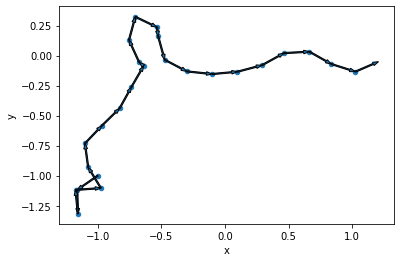

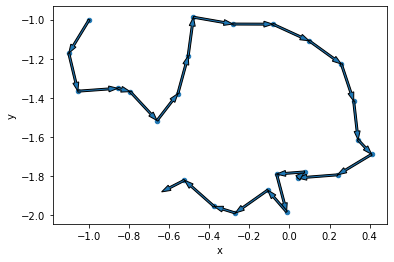

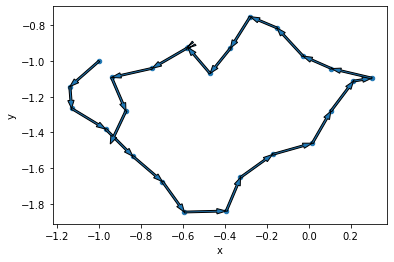

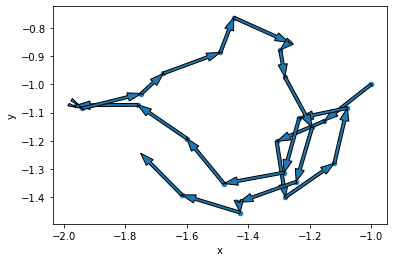

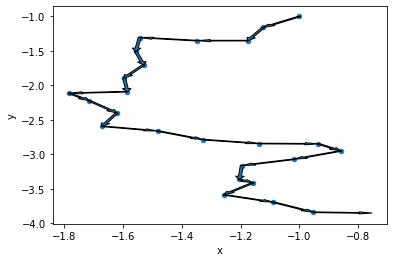

In [16]:
runs = df.run.unique()
for k in runs:
    df[df.run==k].plot(x="x", y='y',kind="scatter")
    r = df[df.run==k].values
    n = len(r)
    for i in range(n):
        plt.arrow(*r[i,:4], width = 0.01, 
        length_includes_head=True)